In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


C:\Users\carlo\AppData\Local\Temp\ipykernel_7292\2009290573.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('availability.csv')
df.rename(columns={'last_update': 'time_of_day'}, inplace=True)
df = df.drop(columns=["status"])
df['time_of_day'] = pd.to_datetime(df['time_of_day'])

# Implement start date at When weather began getting recorded
specified_date_time = pd.to_datetime('2024-02-25 15:03:04')
df = df[df['time_of_day'] >= specified_date_time]

df2 = pd.read_csv('weather.csv')
df2['time_of_day'] = pd.to_datetime(df2['time_of_day'])
df2 = df2.drop(columns=["main"])

#Merge dataframes
merged_df = pd.merge_asof(df.sort_values('time_of_day'), df2.sort_values('time_of_day'), 
                          by='station_id', on='time_of_day', direction='nearest')

merged_df['month'] = pd.to_datetime(merged_df['time_of_day']).dt.month
merged_df['day'] = pd.to_datetime(merged_df['time_of_day']).dt.day
merged_df['hour'] = pd.to_datetime(merged_df['time_of_day']).dt.hour


In [3]:
merged_df = merged_df.sort_values(by='time_of_day')    
merged_df['time_of_day'] = pd.to_datetime(merged_df['time_of_day'])
merged_df['weekday_num'] = merged_df['time_of_day'].dt.weekday + 1  #Adding 1 to match the range 1-7 (Sunday = 7)

#Reassign to DF
df = merged_df
df["description"] = df["description"].astype('category')
df["station_id"] = df["station_id"].astype('category')
df = df.drop(columns=['time_of_day', "available_bike_stands"])
df

,station_id,bike_stands,available_bikes,description,temperature,wind_speed,month,day,hour,weekday_num
0,42,30,30,broken clouds,7,9.77,2,25,15,7
1,32,30,30,broken clouds,8,9.77,2,25,15,7
2,51,40,6,broken clouds,8,9.77,2,25,15,7
3,18,30,24,broken clouds,7,9.77,2,25,15,7
4,57,23,0,broken clouds,7,9.77,2,25,15,7
...,...,...,...,...,...,...,...,...,...,...
949033,3,20,0,broken clouds,14,5.14,4,12,20,5
949034,77,29,8,broken clouds,14,7.72,4,12,20,5
949036,4,20,13,broken clouds,14,5.14,4,12,20,5
949035,88,30,5,broken clouds,14,7.72,4,12,20,5


The idea in the numerous attributes in relation to time allow for a complete dataset that although might be excessive for this size of datset allows for it to be easily scaled, eg after a a years or two of collection, month data and day data could prove to be informative to the model.

To get an idea of demand in regards to day of the week


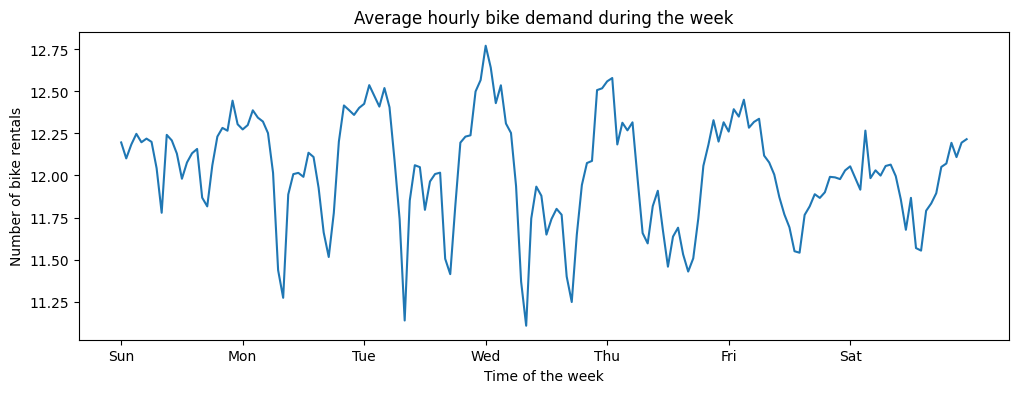

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday_num", "hour"])["available_bikes"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [5]:
#Predictor Variables
X = df.drop("available_bikes", axis="columns")
X

,station_id,bike_stands,description,temperature,wind_speed,month,day,hour,weekday_num
0,42,30,broken clouds,7,9.77,2,25,15,7
1,32,30,broken clouds,8,9.77,2,25,15,7
2,51,40,broken clouds,8,9.77,2,25,15,7
3,18,30,broken clouds,7,9.77,2,25,15,7
4,57,23,broken clouds,7,9.77,2,25,15,7
...,...,...,...,...,...,...,...,...,...
949033,3,20,broken clouds,14,5.14,4,12,20,5
949034,77,29,broken clouds,14,7.72,4,12,20,5
949036,4,20,broken clouds,14,5.14,4,12,20,5
949035,88,30,broken clouds,14,7.72,4,12,20,5


In [6]:
#Target variables
y = df["available_bikes"]
y

0         30
1         30
2          6
3         24
4          0
          ..
949033     0
949034     8
949036    13
949035     5
949037     0
Name: available_bikes, Length: 949038, dtype: int64

In [43]:
from sklearn.model_selection import TimeSeriesSplit
#For a temporal splits to accurately assess accuracy
#Train size based on roughly 105,000 rows is a week a
# test size based on roughly 15,000 rows is a day
# Gap left at 0 due to limited data
#9 splits as around 1 million rows of data
ts_cv = TimeSeriesSplit(
    n_splits=4,
    gap=0,
    max_train_size=210000,
    test_size=15000,
)

In [44]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
# example of splits below

In [45]:
X.iloc[test_0]

,station_id,bike_stands,description,temperature,wind_speed,month,day,hour,weekday_num
889038,37,30,few clouds,11,7.72,4,9,18,2
889039,61,25,few clouds,11,7.72,4,9,18,2
889040,1,31,few clouds,11,7.72,4,9,18,2
889041,36,40,few clouds,11,7.72,4,9,18,2
889042,47,40,few clouds,11,7.72,4,9,18,2
...,...,...,...,...,...,...,...,...,...
904033,53,40,broken clouds,16,8.75,4,10,12,3
904034,13,30,broken clouds,16,8.75,4,10,12,3
904035,112,30,broken clouds,16,8.75,4,10,12,3
904036,67,40,broken clouds,16,8.75,4,10,12,3


In [46]:
X.iloc[train_0]

,station_id,bike_stands,description,temperature,wind_speed,month,day,hour,weekday_num
679038,96,30,few clouds,6,5.14,3,30,5,6
679039,36,40,few clouds,6,5.14,3,30,5,6
679040,106,40,few clouds,6,5.14,3,30,5,6
679041,6,20,few clouds,6,5.14,3,30,5,6
679042,21,30,few clouds,6,5.14,3,30,5,6
...,...,...,...,...,...,...,...,...,...
889033,76,38,few clouds,11,7.72,4,9,18,2
889034,51,40,few clouds,11,7.72,4,9,18,2
889035,26,20,few clouds,11,7.72,4,9,18,2
889036,82,22,few clouds,11,7.72,4,9,18,2


In [47]:
X["description"].value_counts()


description
broken clouds                   513331
scattered clouds                142346
few clouds                       77454
light rain                       75174
light intensity drizzle          38498
moderate rain                    29314
mist                             20849
light intensity drizzle rain     19296
clear sky                        13451
overcast clouds                   6823
light intensity shower rain       4086
fog                               2402
drizzle                           1982
heavy intensity rain              1636
sleet                             1309
snow                               848
shower rain                        239
Name: count, dtype: int64

In [48]:
df.dtypes

station_id         category
bike_stands           int64
available_bikes       int64
description        category
temperature           int64
wind_speed          float64
month                 int32
day                   int32
hour                  int32
weekday_num           int32
dtype: object

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
# I went with histgradientboosting regressor with scikit learn because emphasis on results is not priority, 
# it allows for an easily implementation and it handles time series data pretty well normally, also its native support
# for categorical data makes it ideal


gbrt = HistGradientBoostingRegressor(categorical_features="from_dtype", random_state=42)
categorical_columns = X.columns[X.dtypes == "category"]
print("Categorical features:", categorical_columns.tolist())

Categorical features: ['station_id', 'description']


In [50]:
import numpy as np
from sklearn.model_selection import cross_validate

def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
        f"R-squared:               {r2.mean():.3f} +/- {r2.std():.3f}"
    )


evaluate(gbrt, X, y, cv=ts_cv, model_prop="n_iter_")

Mean model.n_iter_ = 100.0
Mean Absolute Error:     5.249 +/- 0.362
Root Mean Squared Error: 6.773 +/- 0.628
R-squared:               0.460 +/- 0.151


In [52]:
import pickle

fitted_model = gbrt.fit(X, y)
model_filename = 'your_model.pkl'

# Serialize and save the model to the specified file
with open(model_filename, 'wb') as file:
    pickle.dump(fitted_model, file)

print("Model saved successfully as", model_filename)

Model saved successfully as your_model.pkl


In [53]:
with open('your_model.pkl', 'rb') as file:
    model = pickle.load(file)

Mean model.n_iter_ = 100.0
Mean Absolute Error:     5.249 +/- 0.362
Root Mean Squared Error: 6.773 +/- 0.628
R-squared:               0.460 +/- 0.151


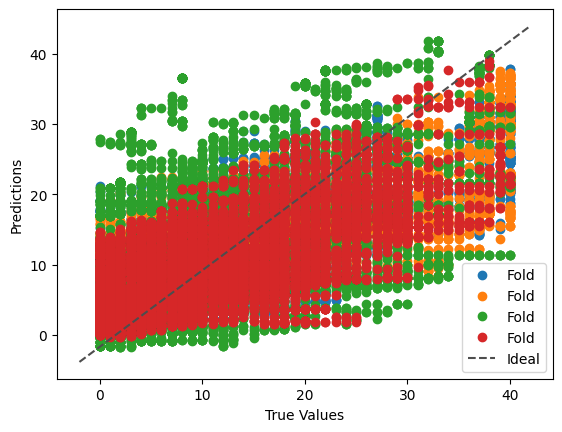

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already defined gbrt, X, y, and ts_cv

def plot_predictions(model, X, y, cv):
    fig, ax = plt.subplots()

    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        ax.plot(y_test, y_pred, 'o', label="Fold")
    
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", label="Ideal")
    ax.legend()
    plt.show()

evaluate(gbrt, X, y, cv=ts_cv, model_prop="n_iter_")
plot_predictions(gbrt, X, y, cv=ts_cv)


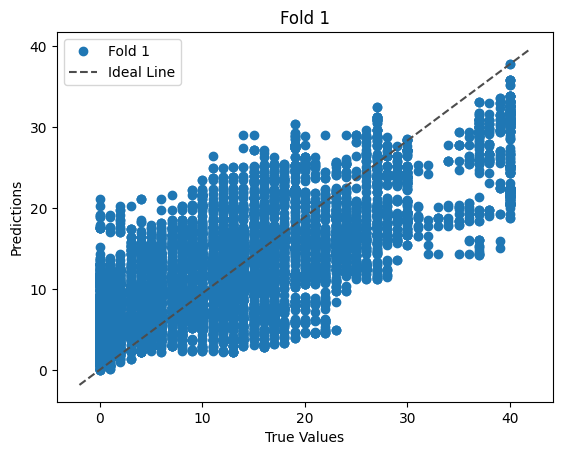

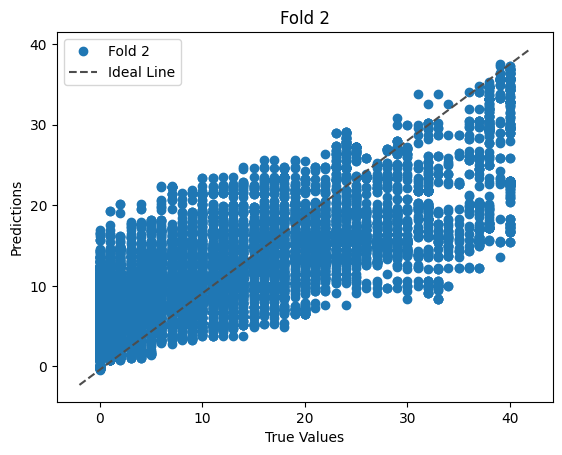

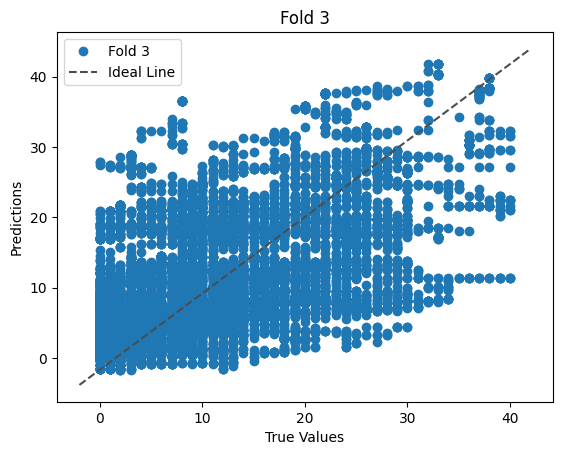

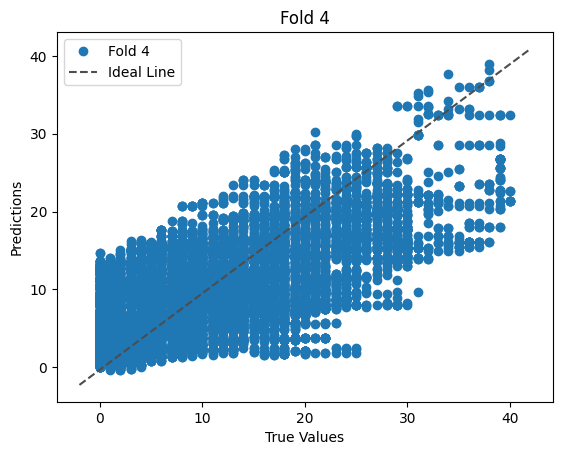

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

def plot_predictions(model, X, y, cv):
    fold = 1
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        fig, ax = plt.subplots()  # Move subplot creation inside the loop
        
        ax.plot(y_test, y_pred, 'o', label=f"Fold {fold}")
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predictions')
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", label="Ideal Line")
        ax.set_title(f'Fold {fold}')
        ax.legend()
        
        plt.show()  # Show each plot individually
        
        fold += 1
plot_predictions(gbrt, X, y, cv=ts_cv)

In [ ]:
"""from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)


evaluate(
    naive_linear_pipeline, X, y, cv=ts_cv, model_prop="alpha_", model_step="ridgecv"
)"""

'from sklearn.linear_model import RidgeCV\nfrom sklearn.preprocessing import MinMaxScaler, OneHotEncoder\n\none_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)\nalphas = np.logspace(-6, 6, 25)\nnaive_linear_pipeline = make_pipeline(\n    ColumnTransformer(\n        transformers=[\n            ("categorical", one_hot_encoder, categorical_columns),\n        ],\n        remainder=MinMaxScaler(),\n    ),\n    RidgeCV(alphas=alphas),\n)\n\n\nevaluate(\n    naive_linear_pipeline, X, y, cv=ts_cv, model_prop="alpha_", model_step="ridgecv"\n)'

In [56]:
times = merged_df.iloc[X[X["station_id"]==100].index]["time_of_day"]
predictions = gbrt.predict(X[X["station_id"]==100])
actual = y[X[X["station_id"]==100].index]

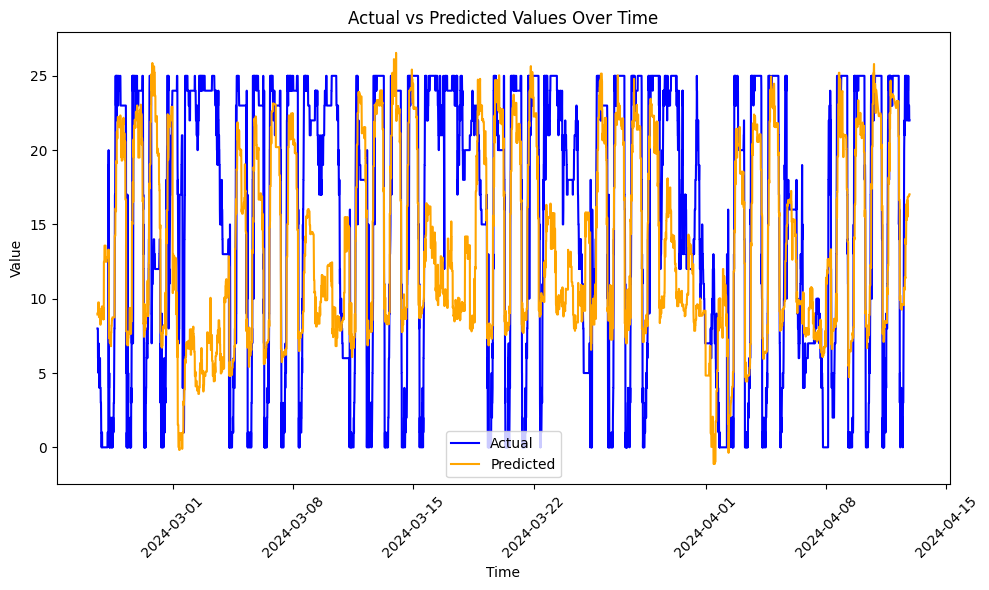

In [57]:
#Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(times, actual, label='Actual', color='blue')
plt.plot(times, predictions, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values Over Time')
plt.legend()
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

In [59]:
import requests
def fetch_weather_data(lat, lng):
    
    API_KEY = 'e09fe30aecb65a55bb36442eda372b92'
    BASE_URL = f" https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lng}&appid={API_KEY}"

    response = requests.get(BASE_URL)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None


In [60]:
data = fetch_weather_data(53.3498,-6.2603)


In [65]:
from datetime import datetime
datetimes = []
temperatures = []

weather_data = []

for item in data['list']:
    dt = datetime.utcfromtimestamp(item['dt'])
    temp = item['main']['temp'] - 273.15  # Convert temperature from Kelvin to Celsius
    wind_speed = item['wind']['speed']
    description = item['weather'][0]['description']
    weather_data.append({'time_of_day': dt, 'wind_speed': wind_speed, 'temperature': temp, 'description': description})


C:\Users\carlo\AppData\Local\Temp\ipykernel_7292\1719328161.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(item['dt'])


In [66]:
df = pd.DataFrame(weather_data)
df

,time_of_day,wind_speed,temperature,description
0,2024-04-13 00:00:00,3.07,12.60,light rain
1,2024-04-13 03:00:00,2.70,11.35,overcast clouds
2,2024-04-13 06:00:00,3.91,11.13,overcast clouds
3,2024-04-13 09:00:00,6.72,13.91,overcast clouds
4,2024-04-13 12:00:00,9.40,12.18,light rain
5,2024-04-13 15:00:00,9.16,11.39,scattered clouds
6,2024-04-13 18:00:00,7.66,8.85,few clouds
7,2024-04-13 21:00:00,6.46,6.36,clear sky
8,2024-04-14 00:00:00,6.07,5.47,clear sky
9,2024-04-14 03:00:00,4.55,4.67,clear sky


In [67]:
df.set_index('time_of_day', inplace=True)

#Generate hourly datetime range
start_date = df.index.min()
end_date = df.index.max()
hourly_range = pd.date_range(start=start_date, end=end_date, freq='H')

#Reindex the DataFrame with hourly datetime range
df = df.reindex(hourly_range)

#Interpolate missing values
df_interpolated = df.interpolate(method='linear')
         

df_interpolated['description'] = df_interpolated['description'].fillna(method='ffill')
df_interpolated = df_interpolated.iloc[:24]
# Print the interpolated DataFrame
df_interpolated

C:\Users\carlo\AppData\Local\Temp\ipykernel_7292\3036747901.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_range = pd.date_range(start=start_date, end=end_date, freq='H')
C:\Users\carlo\AppData\Local\Temp\ipykernel_7292\3036747901.py:12: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df.interpolate(method='linear')
C:\Users\carlo\AppData\Local\Temp\ipykernel_7292\3036747901.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_interpolated['description'] = df_interpolated['description'].fillna(method='ffill')


,wind_speed,temperature,description
2024-04-13 00:00:00,3.070000,12.600000,light rain
2024-04-13 01:00:00,2.946667,12.183333,light rain
2024-04-13 02:00:00,2.823333,11.766667,light rain
2024-04-13 03:00:00,2.700000,11.350000,overcast clouds
2024-04-13 04:00:00,3.103333,11.276667,overcast clouds
2024-04-13 05:00:00,3.506667,11.203333,overcast clouds
2024-04-13 06:00:00,3.910000,11.130000,overcast clouds
2024-04-13 07:00:00,4.846667,12.056667,overcast clouds
2024-04-13 08:00:00,5.783333,12.983333,overcast clouds
2024-04-13 09:00:00,6.720000,13.910000,overcast clouds


In [68]:
df_interpolated.reset_index(inplace=True)
df_interpolated.rename(columns={'index': 'time_of_day'}, inplace=True)
df_interpolated

,time_of_day,wind_speed,temperature,description
0,2024-04-13 00:00:00,3.070000,12.600000,light rain
1,2024-04-13 01:00:00,2.946667,12.183333,light rain
2,2024-04-13 02:00:00,2.823333,11.766667,light rain
3,2024-04-13 03:00:00,2.700000,11.350000,overcast clouds
4,2024-04-13 04:00:00,3.103333,11.276667,overcast clouds
5,2024-04-13 05:00:00,3.506667,11.203333,overcast clouds
6,2024-04-13 06:00:00,3.910000,11.130000,overcast clouds
7,2024-04-13 07:00:00,4.846667,12.056667,overcast clouds
8,2024-04-13 08:00:00,5.783333,12.983333,overcast clouds
9,2024-04-13 09:00:00,6.720000,13.910000,overcast clouds


In [69]:
def fetch_decaux_data():
    CONTRACT_NAME = "dublin"
    API_KEY = '99d3e65801ab0bdae585264b25d443c5545365b5'
    BASE_URL = f"https://api.jcdecaux.com/vls/v1/stations?contract={CONTRACT_NAME}&apiKey={API_KEY}"

    response = requests.get(BASE_URL)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None
    
station_data = fetch_decaux_data()



In [70]:
#Extracting station_id and bike_stands from each dictionary in the data list
station_df = [{'station_id': d['number'], 'bike_stands': d['bike_stands']} for d in station_data]

# Creating DataFrame
df = pd.DataFrame(station_df)
df_interpolated.reset_index(drop=True, inplace=True)

df

,station_id,bike_stands
0,42,30
1,30,20
2,54,33
3,108,35
4,20,30
...,...,...
109,39,20
110,83,40
111,92,40
112,21,30


In [71]:
df3 = df_interpolated.merge(df, how ="cross")
df3['time_of_day'] = pd.to_datetime(df3['time_of_day'])
df3['month'] = pd.to_datetime(df3['time_of_day']).dt.month
df3['day'] = pd.to_datetime(df3['time_of_day']).dt.day
df3['hour'] = pd.to_datetime(df3['time_of_day']).dt.hour
df3['weekday_num'] = df3['time_of_day'].dt.weekday + 1  # Adding 1 to match the range 1-7 (Sunday = 7)


df3[df3["station_id"]==42]


,time_of_day,wind_speed,temperature,description,station_id,bike_stands,month,day,hour,weekday_num
0,2024-04-13 00:00:00,3.070000,12.600000,light rain,42,30,4,13,0,6
114,2024-04-13 01:00:00,2.946667,12.183333,light rain,42,30,4,13,1,6
228,2024-04-13 02:00:00,2.823333,11.766667,light rain,42,30,4,13,2,6
342,2024-04-13 03:00:00,2.700000,11.350000,overcast clouds,42,30,4,13,3,6
456,2024-04-13 04:00:00,3.103333,11.276667,overcast clouds,42,30,4,13,4,6
570,2024-04-13 05:00:00,3.506667,11.203333,overcast clouds,42,30,4,13,5,6
684,2024-04-13 06:00:00,3.910000,11.130000,overcast clouds,42,30,4,13,6,6
798,2024-04-13 07:00:00,4.846667,12.056667,overcast clouds,42,30,4,13,7,6
912,2024-04-13 08:00:00,5.783333,12.983333,overcast clouds,42,30,4,13,8,6
1026,2024-04-13 09:00:00,6.720000,13.910000,overcast clouds,42,30,4,13,9,6


In [78]:
predictions = model.predict(df3[df3["station_id"]==100])
times = df3.iloc[df3[df3["station_id"]==100].index]["time_of_day"]
times_formatted = times.dt.strftime('%d %H')


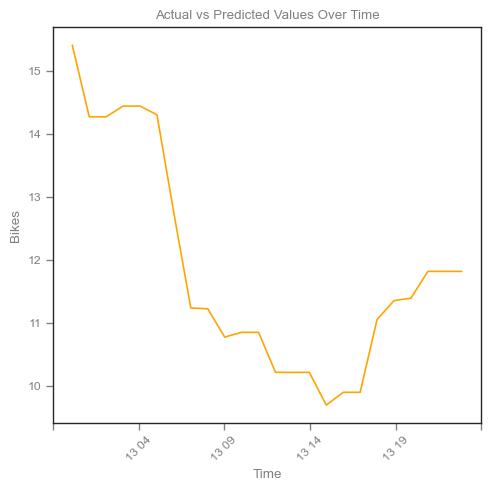

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

sns.set_style("ticks")
sns.set_context("paper")
plt.figure(figsize=(5, 5))

plot = sns.lineplot(x=times_formatted, y=predictions, color='orange')
plt.xlabel('Time', color='grey')
plt.ylabel('Bikes', color='grey')
plt.title('Actual vs Predicted Values Over Time', color='grey')
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')


plt.xticks(rotation=45)  
plot.xaxis.set_major_locator(ticker.LinearLocator(6))

plt.tight_layout()  
plt.show()


In [81]:
model.predict(df3[df3["station_id"]==100])

array([15.41609202, 14.27588638, 14.27588638, 14.44657489, 14.44657489,
       14.3081171 , 12.74056608, 11.23449401, 11.2216787 , 10.77114549,
       10.84683243, 10.84683243, 10.20996015, 10.20996015, 10.20996015,
        9.68897023,  9.89251692,  9.89251692, 11.05004436, 11.35090165,
       11.39040028, 11.81656575, 11.81656575, 11.81656575])